In [ ]:
LOCAL = False
import os
import importlib

if LOCAL:
    path = '/Users/berk/Documents/research/nna/src/scripts/'
else:
    path = '/home/enis/projects/nna/src/scripts/'
os.chdir(path)

import teacher
from nna import weather

# import itertools
import pandas as pd

import numpy as np
import random


Output(layout=Layout(border='1px solid black'))

In [ ]:
importlib.reload(teacher)
importlib.reload(weather)

version_tag = 'weather_V5'
dataset_version = 'W5'

FILE_PER_LOCATION = 30000
TIMESTAMPS_PER_ROW = 4

config = teacher.setup(versiontag=version_tag)

if LOCAL:
    weather_data_folder = '/Users/berk/Downloads/NNA_files/weather_data/2017_2020'
else:
    weather_data_folder = '/scratch/enis/data/nna/weather_data/2017_2020'

root_path = '/scratch/enis/data/nna/labeling/samples'
config['split_out_path'] = f'{root_path}/{version_tag}/audio_'

## data-1: as many sampes as possible
config['new_dataset_path'] = f'{root_path}/{version_tag}/{version_tag}.csv'
config['dataset_version'] = dataset_version
# config['versiontag'] = 'yfitloiq-V1'
config['excell_label_headers'] = [
    'day_length', 'air_temp', 'snow_depth', 'cloud_fraction',
    'relative_humidity', 'runoff', 'rain_precip', 'snow_precip',
    'wind_direction', 'wind_speed'
]

# config['excell_label_headers']=['day_length','air_temp','snow_depth',
#         'cloud_fraction','relative_humidity','runoff','rain_precip',
#          'snow_precip','wind_direction','wind_speed',
#         'snow_blowing_ground','snow_blowing_air',]

config['upper_taxo_links'] = {}

# print('total sample count to be produced:',file_per_location*len(short_ones.keys()))

# 40 Prudhoe or ANWR monitoring sites AND the Ivvavik sites
short_input_csv_headers = [
    'day_length', 'air_temp', 'snow_depth', 'cloud_fraction',
    'relative_humidity', 'runoff', 'rain_precip', 'snow_precip',
    'wind_direction', 'wind_speed'
]
# (year,month,day,hour,day_length,air_temp,snow_depth,
#                 cloud_fraction,relative_humidity,runoff,rain_precip,
#                     snow_precip,wind_direction,wind_speed)=row
# for Dalton and Dempster
long_input_csv_headers = [
    'day_length', 'air_temp', 'snow_depth', 'cloud_fraction',
    'relative_humidity', 'runoff', 'rain_precip', 'snow_precip', 'total_precip',
    'wind_direction', 'wind_speed', 'snow_blowing_ground', 'snow_blowing_air'
]

excell_all_headers = [
    'data_version', 'Annotator', 'Site ID', 'File Name', 'Date', 'Start Time',
    'End Time', 'Length', 'Clip Path', 'Comments', 'weather_timestamp',
    'region', 'day_length', 'air_temp', 'snow_depth', 'cloud_fraction',
    'relative_humidity', 'runoff', 'rain_precip', 'rain_precip_mm',
    'snow_precip', 'wind_direction', 'wind_speed'
]

# (year,month,day,hour,day_length,air_temp,snow_depth,
# cloud_fraction,relative_humidity,runoff,rain_precip,
# snow_precip,total_precip,wind_direction,wind_speed,
# snow_blowing_ground,snow_blowing_air)=row

short_locations = ('prudhoe', 'ivvavik', 'anwr')
long_locations = ('dalton', 'dempster')

if LOCAL:
    file_database = '/Users/berk/Documents/scratch/enis/data/nna/database/allFields_dataV10.pkl'
else:
    file_database = '/scratch/enis/data/nna/database/allFields_dataV10.pkl'

neon_weather_data_path = '/scratch/enis/data/nna/weather_data/NEON_precipitation/'
NEON_LENGTH_MIN = 5


In [10]:
def generate_new_dataset4weather_rows_v2(region, location, file_properties_df,
                                         weather_data, file_per_location):

    filtered_files = file_properties_df[file_properties_df['region'] == region]
    filtered_files = filtered_files[filtered_files['locationId'] == location]

    # weather_data = weather.load_weather_data(region, location, fname, short_locations,
    #                                  long_locations, short_input_csv_headers,
    #                                  long_input_csv_headers)

    # Find the earliest start and end timestamps in weather_data
    earliest_start = weather_data['TIMESTAMP'].min()
    earliest_end = weather_data['TIMESTAMP'].max()

    # Filter the rows of filtered_files dataframe
    filtered_files = filtered_files[
        (filtered_files['timestamp'] >= earliest_start) &
        (filtered_files['timestampEnd'] <= earliest_end)]

    # Check if filtered_files is empty
    if filtered_files.empty:
        print('No matching files found!')
    else:
        weather_rows = weather.get_weather_rows(filtered_files,
                                                weather_data,
                                                file_per_location,
                                                weather_data_freq=60 *
                                                NEON_LENGTH_MIN)
        buffer_seconds = 0

        new_dataset_csv, not_found_rows = teacher.generate_new_dataset(
            weather_rows,
            config['versiontag'],
            config['split_out_path'],
            file_properties_df,
            config['upper_taxo_links'],
            config['dataset_version'],
            buffer=buffer_seconds,
            excell_label_headers={},  #config['excell_label_headers'],
            labels_thresholds={},  #config['labels_thresholds'],
            outputSuffix='.wav',
            dry_run=False,
            excell_labels_2_names={},  #config['excell_labels_2_names'],
            stereo2mono=True,
            overwrite=True,
            sampling_rate=48000,
            label_row_by_threshold=False,
            print_logs=False,
        )
        return new_dataset_csv, not_found_rows, weather_rows

    return [], [], pd.DataFrame()

In [4]:
file_properties_df = pd.read_pickle(file_database)
station_csv = weather.csv_path_per_regloc(weather_data_folder)
station_years = weather.year_per_regloc(station_csv, file_properties_df)


In [6]:
# neon_df = weather.load_neon_data(neon_weather_data_path,length=5,local_time_zone='America/Anchorage')
# # neon_df=neon_df[neon_df['priPrecipFinalQF']==0].copy() # keep only good quality data
# # 1mm/3hrs = x/5min
# # x = 5min/180min
# x=5/(3*60)
# x

In [9]:
# file_properties_df=file_properties_df[(file_properties_df['region']=='dalton') & (file_properties_df['locationId']=='09')].copy()
# file_properties_df=file_properties_df[].copy()


In [76]:
weather_data[weather_data['priPrecipBulk'].isna()]

,startDateTime,endDateTime,priPrecipBulk,priPrecipExpUncert,priPrecipFinalQF,location,region,TIMESTAMP,timestamp_start,timestamp_end
18228,2018-03-04 22:00:00,2018-03-04 22:05:00,NaN,NaN,1,09,dalton,2018-03-04 22:00:00,2018-03-04 22:00:00,2018-03-04 22:05:00
18229,2018-03-04 22:05:00,2018-03-04 22:10:00,NaN,NaN,1,09,dalton,2018-03-04 22:05:00,2018-03-04 22:05:00,2018-03-04 22:10:00
18230,2018-03-04 22:10:00,2018-03-04 22:15:00,NaN,NaN,1,09,dalton,2018-03-04 22:10:00,2018-03-04 22:10:00,2018-03-04 22:15:00
18231,2018-03-04 22:15:00,2018-03-04 22:20:00,NaN,NaN,1,09,dalton,2018-03-04 22:15:00,2018-03-04 22:15:00,2018-03-04 22:20:00
18232,2018-03-04 22:20:00,2018-03-04 22:25:00,NaN,NaN,1,09,dalton,2018-03-04 22:20:00,2018-03-04 22:20:00,2018-03-04 22:25:00
...,...,...,...,...,...,...,...,...,...,...
549224,2023-03-22 16:40:00,2023-03-22 16:45:00,NaN,NaN,1,09,dalton,2023-03-22 16:40:00,2023-03-22 16:40:00,2023-03-22 16:45:00
549225,2023-03-22 16:45:00,2023-03-22 16:50:00,NaN,NaN,1,09,dalton,2023-03-22 16:45:00,2023-03-22 16:45:00,2023-03-22 16:50:00
549226,2023-03-22 16:50:00,2023-03-22 16:55:00,NaN,NaN,1,09,dalton,2023-03-22 16:50:00,2023-03-22 16:50:00,2023-03-22 16:55:00
549227,2023-03-22 16:55:00,2023-03-22 17:00:00,NaN,NaN,1,09,dalton,2023-03-22 16:55:00,2023-03-22 16:55:00,2023-03-22 17:00:00


In [11]:
file_per_location = FILE_PER_LOCATION
new_dataset_csv, not_found_rows = [], []
df_per_location = []
not_found_per_location = {}
region = 'dalton'
location = '09'

print('region:', region, 'location:', location)
weather_data = weather.load_neon_data(neon_weather_data_path,
                                      length=NEON_LENGTH_MIN,
                                      region=region,
                                      location=location)

new_dataset, not_found, weather_rows = generate_new_dataset4weather_rows_v2(
    region, location, file_properties_df, weather_data, file_per_location)

new_dataset_df = pd.DataFrame(new_dataset).reset_index(drop=True)
weather_rows_df = weather_rows.reset_index(drop=True)

# convert TIMESTAMP and Start Time columns to datetime format
weather_rows['TIMESTAMP'] = pd.to_datetime(weather_rows['TIMESTAMP'])
new_dataset_df['TIMESTAMP'] = pd.to_datetime(new_dataset_df['Date'] + ' ' +
                                             new_dataset_df['Start Time'])
new_dataset_df.drop_duplicates(subset=['TIMESTAMP'], inplace=True)

combined = pd.merge(weather_rows, new_dataset_df, on=['TIMESTAMP'], how='inner')

df_per_location.append(combined)
not_found_per_location[(region, location)] = not_found
if len(not_found) != 0:
    print(f'not_found is not empty {len(not_found)}')

dataset = pd.concat(df_per_location)

region: dalton location: 09


AssertionError: len(new_dataset_csv) != len(weather_rows)

In [62]:
new_dataset_df.drop_duplicates(subset=['TIMESTAMP'], inplace=True)
weather_rows.drop_duplicates(subset=['TIMESTAMP'], inplace=True)
new_dataset_df.shape

(29603, 11)

In [60]:
weather_rows

,startDateTime,endDateTime,priPrecipBulk,priPrecipExpUncert,priPrecipFinalQF,location,region,TIMESTAMP,timestamp_start,timestamp_end,timestamp_orig_weather
171520,2019-08-19 05:20:00,2019-08-19 05:25:00,NaN,NaN,1,09,dalton,2019-08-19 05:24:44,2019-08-19 05:20:00,2019-08-19 05:25:00,2019-08-19 05:20:00
173824,2019-08-27 05:20:00,2019-08-27 05:25:00,0.02,0.001,0,09,dalton,2019-08-27 05:20:01,2019-08-27 05:20:00,2019-08-27 05:25:00,2019-08-27 05:20:00
187584,2019-10-14 00:00:00,2019-10-14 00:05:00,0.00,0.000,0,09,dalton,2019-10-14 00:00:24,2019-10-14 00:00:00,2019-10-14 00:05:00,2019-10-14 00:00:00
183104,2019-09-28 10:40:00,2019-09-28 10:45:00,0.00,0.000,0,09,dalton,2019-09-28 10:40:48,2019-09-28 10:40:00,2019-09-28 10:45:00,2019-09-28 10:40:00
357182,2021-05-24 21:10:00,2021-05-24 21:15:00,0.00,0.000,0,09,dalton,2021-05-24 21:13:30,2021-05-24 21:10:00,2021-05-24 21:15:00,2021-05-24 21:10:00
...,...,...,...,...,...,...,...,...,...,...,...
154825,2019-06-22 06:05:00,2019-06-22 06:10:00,0.00,0.000,0,09,dalton,2019-06-22 06:06:13,2019-06-22 06:05:00,2019-06-22 06:10:00,2019-06-22 06:05:00
127986,2019-03-21 01:30:00,2019-03-21 01:35:00,0.00,0.000,1,09,dalton,2019-03-21 01:33:49,2019-03-21 01:30:00,2019-03-21 01:35:00,2019-03-21 01:30:00
335290,2021-03-09 19:50:00,2021-03-09 19:55:00,0.00,0.000,0,09,dalton,2021-03-09 19:53:28,2021-03-09 19:50:00,2021-03-09 19:55:00,2021-03-09 19:50:00
337391,2021-03-17 03:55:00,2021-03-17 04:00:00,0.00,0.000,0,09,dalton,2021-03-17 03:56:16,2021-03-17 03:55:00,2021-03-17 04:00:00,2021-03-17 03:55:00


In [66]:
combined = pd.merge(weather_rows, new_dataset_df, on=['TIMESTAMP'], how='inner')
dataset = combined.copy()

(29604, 11)

In [49]:
weather_rows.shape

(30000, 11)

In [44]:
weather_rows_df

,startDateTime,endDateTime,priPrecipBulk,priPrecipExpUncert,priPrecipFinalQF,location,region,TIMESTAMP,timestamp_start,timestamp_end,timestamp_orig_weather
0,2019-08-19 05:20:00,2019-08-19 05:25:00,NaN,NaN,1,09,dalton,2019-08-19 05:24:44,2019-08-19 05:20:00,2019-08-19 05:25:00,2019-08-19 05:20:00
1,2019-08-27 05:20:00,2019-08-27 05:25:00,0.02,0.001,0,09,dalton,2019-08-27 05:20:01,2019-08-27 05:20:00,2019-08-27 05:25:00,2019-08-27 05:20:00
2,2019-10-14 00:00:00,2019-10-14 00:05:00,0.00,0.000,0,09,dalton,2019-10-14 00:00:24,2019-10-14 00:00:00,2019-10-14 00:05:00,2019-10-14 00:00:00
3,2019-09-28 10:40:00,2019-09-28 10:45:00,0.00,0.000,0,09,dalton,2019-09-28 10:40:48,2019-09-28 10:40:00,2019-09-28 10:45:00,2019-09-28 10:40:00
4,2021-05-24 21:10:00,2021-05-24 21:15:00,0.00,0.000,0,09,dalton,2021-05-24 21:13:30,2021-05-24 21:10:00,2021-05-24 21:15:00,2021-05-24 21:10:00
...,...,...,...,...,...,...,...,...,...,...,...
29995,2019-06-22 06:05:00,2019-06-22 06:10:00,0.00,0.000,0,09,dalton,2019-06-22 06:06:13,2019-06-22 06:05:00,2019-06-22 06:10:00,2019-06-22 06:05:00
29996,2019-03-21 01:30:00,2019-03-21 01:35:00,0.00,0.000,1,09,dalton,2019-03-21 01:33:49,2019-03-21 01:30:00,2019-03-21 01:35:00,2019-03-21 01:30:00
29997,2021-03-09 19:50:00,2021-03-09 19:55:00,0.00,0.000,0,09,dalton,2021-03-09 19:53:28,2021-03-09 19:50:00,2021-03-09 19:55:00,2021-03-09 19:50:00
29998,2021-03-17 03:55:00,2021-03-17 04:00:00,0.00,0.000,0,09,dalton,2021-03-17 03:56:16,2021-03-17 03:55:00,2021-03-17 04:00:00,2021-03-17 03:55:00


In [23]:
weather_rows_df['TIMESTAMP'].unique().shape

(29604,)

In [26]:
# drop duplicates by TIMESTAMP
new_dataset_df_dropped = new_dataset_df.drop_duplicates(subset=['TIMESTAMP'])


In [22]:
new_dataset_df.shape, weather_rows_df.shape


((29995, 11), (30000, 11))

In [14]:
new_dataset_df = pd.DataFrame(new_dataset).reset_index(drop=True)
weather_rows_df = weather_rows.reset_index(drop=True)

# convert TIMESTAMP and Start Time columns to datetime format
weather_rows['TIMESTAMP'] = pd.to_datetime(weather_rows['TIMESTAMP'])
new_dataset_df['TIMESTAMP'] = pd.to_datetime(new_dataset_df['Date'] + ' ' +
                                             new_dataset_df['Start Time'])
new_dataset_df.drop_duplicates(subset=['TIMESTAMP'], inplace=True)
combined = pd.merge(weather_rows, new_dataset_df, on=['Clip Path'], how='right')

df_per_location.append(combined)
not_found_per_location[(region, location)] = not_found
if len(not_found) != 0:
    print(f'not_found is not empty {len(not_found)}')

dataset = pd.concat(df_per_location)

not_found is not empty 5


In [31]:
dataset = pd.merge(weather_rows,
                   new_dataset_df_dropped,
                   on=['TIMESTAMP'],
                   how='inner')


In [90]:
dataset.shape

(26522, 21)

In [68]:
dataset.drop_duplicates(subset=['Clip Path'], inplace=True)

In [78]:
dataset_backup = dataset.copy()
dataset_backup.shape

(29603, 21)

In [88]:
dataset.dropna(inplace=True)

In [91]:
config['new_dataset_path']
'/scratch/enis/data/nna/labeling/samples/weather_V5/weather_V5_dropna.csv'

'/scratch/enis/data/nna/labeling/samples/weather_V5/weather_V5.csv'

In [42]:
assert dataset['Clip Path'].unique(
).shape[0] == dataset.shape[0], 'Clip Path is not unique'
dataset['weather_timestamp'] = dataset['timestamp_orig_weather']
dataset[excell_all_headers[:12] + [
    'priPrecipBulk',
    'priPrecipExpUncert',
    'priPrecipFinalQF',
]].to_csv(
    '/scratch/enis/data/nna/labeling/samples/weather_V5/weather_V5_dropna.csv',
    index=False,
    header=True,
)


In [135]:
dataset['Clip Path'].unique().shape[0], dataset.shape[0]


(29402, 29402)

In [12]:
# dataset=dataset.drop_duplicates(subset=['Clip Path'])

In [136]:
dataset[['rain_precip', 'rain_precip_mm']]


,rain_precip,rain_precip_mm
0,4.041561e-07,0.000404
1,0.000000e+00,0.000000
2,0.000000e+00,0.000000
3,1.713461e-04,0.171346
4,0.000000e+00,0.000000
...,...,...
29397,6.268318e-05,0.062683
29398,0.000000e+00,0.000000
29399,0.000000e+00,0.000000
29400,0.000000e+00,0.000000


In [147]:
dataset[dataset['rain_precip_mm'] == 0]


,location,region,TIMESTAMP,day_length,air_temp,snow_depth,cloud_fraction,relative_humidity,runoff,rain_precip,...,Site ID,File Name,Start Time,End Time,Date,Length,Clip Path,Comments,TIMESTAMP_excerpt,weather_timestamp
1,09,dalton,2019-05-03 09:31:03,17.942587,-3.385193,0.315714,0.831613,69.618080,0.0,0.0,...,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,09:31:03.000000,09:31:13.000000,05/03/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-05-03 09:31:03,2019-05-03 09:00:00
2,09,dalton,2019-05-07 14:50:41,18.585709,-6.407867,0.342108,0.831613,82.216835,0.0,0.0,...,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,14:50:41.000000,14:50:51.000000,05/07/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-05-07 14:50:41,2019-05-07 12:00:00
4,09,dalton,2019-10-10 16:01:57,9.401464,-3.753754,0.204732,0.831613,84.921227,0.0,0.0,...,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,16:01:57.000000,16:02:07.000000,10/10/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-10-10 16:01:57,2019-10-10 15:00:00
5,09,dalton,2019-04-12 06:52:38,14.828531,-1.907745,0.380435,0.831613,74.602035,0.0,0.0,...,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,06:52:38.000000,06:52:48.000000,04/12/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-04-12 06:52:38,2019-04-12 06:00:00
8,09,dalton,2019-10-17 13:23:03,8.402626,-11.715057,0.220415,0.806718,73.971428,0.0,0.0,...,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,13:23:03.000000,13:23:13.000000,10/17/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-10-17 13:23:03,2019-10-17 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29395,09,dalton,2019-09-22 17:20:48,11.905133,-2.981506,0.110733,0.831613,91.848389,0.0,0.0,...,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,17:20:48.000000,17:20:58.000000,09/22/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-09-22 17:20:48,2019-09-22 15:00:00
29396,09,dalton,2019-03-31 00:12:53,13.010199,-6.858002,0.380962,0.831613,75.979515,0.0,0.0,...,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,00:12:53.000000,00:13:03.000000,03/31/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-03-31 00:12:53,2019-03-31 00:00:00
29398,09,dalton,2019-04-19 01:31:12,15.687706,-17.467804,0.495033,0.831613,81.255524,0.0,0.0,...,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,01:31:12.000000,01:31:22.000000,04/19/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-04-19 01:31:12,2019-04-19 00:00:00
29399,09,dalton,2019-04-30 18:53:59,17.474737,3.680267,0.371104,0.425391,48.611893,0.0,0.0,...,09,/tank/data/nna/real/dalton/09/2019/S4A10422_20...,18:53:59.000000,18:54:09.000000,04/30/2019,00:00:10.000000,/scratch/enis/data/nna/labeling/samples/weathe...,,2019-04-30 18:53:59,2019-04-30 18:00:00


In [35]:
dataset['timestamp_orig_weather'].unique().shape[0], dataset.shape[0]


(2483, 14800)

<AxesSubplot:>

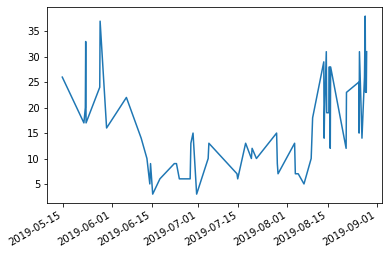

In [143]:
dataset[dataset['rain_precip_mm'] > 1]['timestamp_orig_weather'].value_counts(
).plot()


In [138]:
%matplotlib inline